# Hare and Lynx - PySindy
This jupyter notebook contains the code with the passages used to solve the assigment's first problem.  
Course name: "Modelling from measurements",  held by prof. Nathan Kutz in Politecnico di Milano, June 2022.  
Optimal DMD for python: https://github.com/kunert/py-optDMD  
PySindy examples: https://github.com/dynamicslab/pysindy/tree/master/examples  
Pysindy GitHUb: https://github.com/dynamicslab/pysindy 

In [1]:
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
from scipy import interpolate
import os
from pathlib import Path

cwd = os.getcwd()

import warnings
from scipy.integrate.odepack import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=ODEintWarning)

# integration keywords for solve_ivp, typically needed for chaotic systems
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

# Intepolate?
spline_flag = True

# Dataset definition
hare =  [20, 20, 52, 83, 64, 68, 83, 12, 36, 150, 110, 60, 7, 10, 70, 100, 92, 70, 10, 11, 137, 137, 18, 22, 52, 83, 18, 10, 9, 65],
lynx =  [32, 50, 12, 10, 13, 36, 15, 12, 6, 6, 65, 70, 40, 9, 20, 34, 45, 40, 15, 15, 60, 80, 26, 18, 37, 50, 35, 12, 12, 25],

dt = 2
t0 = 1845
t1 = 1904
t_train = np.arange(t0, t1, dt)
#t_train = np.reshape(t_train, (1,30))
X_train = np.concatenate((np.array(hare),np.array(lynx)), axis=0).transpose()

def interpolation(t ,X, t_new):

    f_0 = interpolate.splrep(t, X[:,0])
    f_1 = interpolate.splrep(t, X[:,1])

    X_new = np.zeros((len(t_new),2))
    X_new[:,0] = interpolate.splev(t_new, f_0)
    X_new[:,1] = interpolate.splev(t_new, f_1)

    return X_new

if spline_flag:
    dt = 0.5
    t_train_new = np.arange(t0,t1,dt)
    X_train = interpolation(t_train, X_train, t_train_new)
    print(f"Interpolation used; dt = {dt}")

t_train = t_train_new

# Directory for the images
image_dir = os.path.join(cwd, "Images")
Path(image_dir).mkdir(parents=True, exist_ok=True)


Interpolation used; dt = 0.5


# PySindy single model
As first step, we fit a regular Sindy model without ensembling.  
One might notice that there are different solutions when the optimizer threshold is changed, as well as the number of polynomial's degrees.

In [2]:
# Custom feature names.
feat_names = ['hare','lynx']

# Differentiation method for SINDY
diff_method = ps.FiniteDifference(order=2)

# Definition of the library
feat_library = ps.PolynomialLibrary(degree=5)

# Optimizer (Under threshold the coefficient are directly imposed = 0. Default is 0.1)
optimizer = ps.STLSQ(threshold=0.01, max_iter=200)

# Inizialization of the SINDY model:
model = ps.SINDy(
    differentiation_method=diff_method,
    feature_library=feat_library,
    optimizer=optimizer,
    feature_names=feat_names
)



# Fitting of a single model
model.fit(X_train, t=t_train)

# We can visualize the data by means of .print() method
model.print()

(hare)' = 13.162 1 + 0.148 hare + -0.656 lynx
(lynx)' = -4.070 1 + 0.143 hare + -0.125 lynx


/home/luca/tensorflow-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.83364e-24): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/luca/tensorflow-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.83364e-24): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


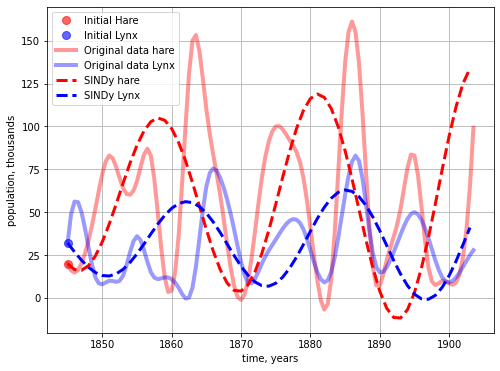

In [3]:
# Let's see the evolution of the sindy model in time:
hare0 = X_train[0,0]
lynx0 = X_train[0,1]

dt_test = 1
t_test = np.arange(t0, t1, dt_test)

# Generate a simulation with the SINDy model:
sim = model.simulate([hare0, lynx0], t=t_test)


# Plot the results
plt.figure(facecolor='white', figsize=(8, 6))

# Initial conditions
plt.plot(t0, hare0, "ro", label="Initial Hare", alpha=0.6, markersize=8)
plt.plot(t0, lynx0, "bo", label="Initial Lynx", alpha=0.6, markersize=8)

# Original Data
plt.plot(t_train, X_train[:,0], "r", label="Original data hare", alpha=0.4, linewidth=4)
plt.plot(t_train, X_train[:,1], "b", label="Original data Lynx", alpha=0.4, linewidth=4)

# PySindy simulation
plt.plot(t_test, sim[:, 0], "r--", label="SINDy hare", linewidth=3)
plt.plot(t_test, sim[:, 1], "b--", label="SINDy Lynx", linewidth=3)
plt.grid()
plt.xlabel("time, years")
plt.ylabel("population, thousands")
plt.legend()
plt.savefig(os.path.join(image_dir, "hl_sindy"))
plt.show()

del model

# Pysindy Ensemble model - bagging samples and library
By bagging on samples and library, with n_models=100 we get 10.000 total models. The noise of different models should be smoothered out and get more robust results.

In [4]:
# regularizer for the optimizer
alpha = 0.0004

# Let's define again some parameters
diff_method_bag = ps.FiniteDifference(order=2)
feat_library_bag = ps.PolynomialLibrary(degree=3)
optimizer_bag = ps.STLSQ(threshold=0.001, max_iter=200, alpha = alpha)


model_bag = ps.SINDy(
    differentiation_method=diff_method_bag,
    feature_library=feat_library_bag,
    optimizer=optimizer_bag,
    feature_names=feat_names,
)

model_bag.fit(
    X_train,
    t=t_train,
    ensemble=True,
    library_ensemble=True,
    replace=True,
    n_candidates_to_drop=2,
    n_subset=90, # number of time points to use for ensemble
    n_models=100,
    quiet = True,
    
)
# lambda x: np.median(x, axis=0)

coefs_bag = model_bag.coef_list
model_bag.print() # Printing THE LAST MODEL ONLY

(hare)' = 0.244 1 + 0.385 hare + -0.001 lynx + 0.006 hare^2 + -0.018 hare lynx
(lynx)' = 0.044 1 + -0.029 hare + 0.002 hare^2 + -0.003 hare lynx


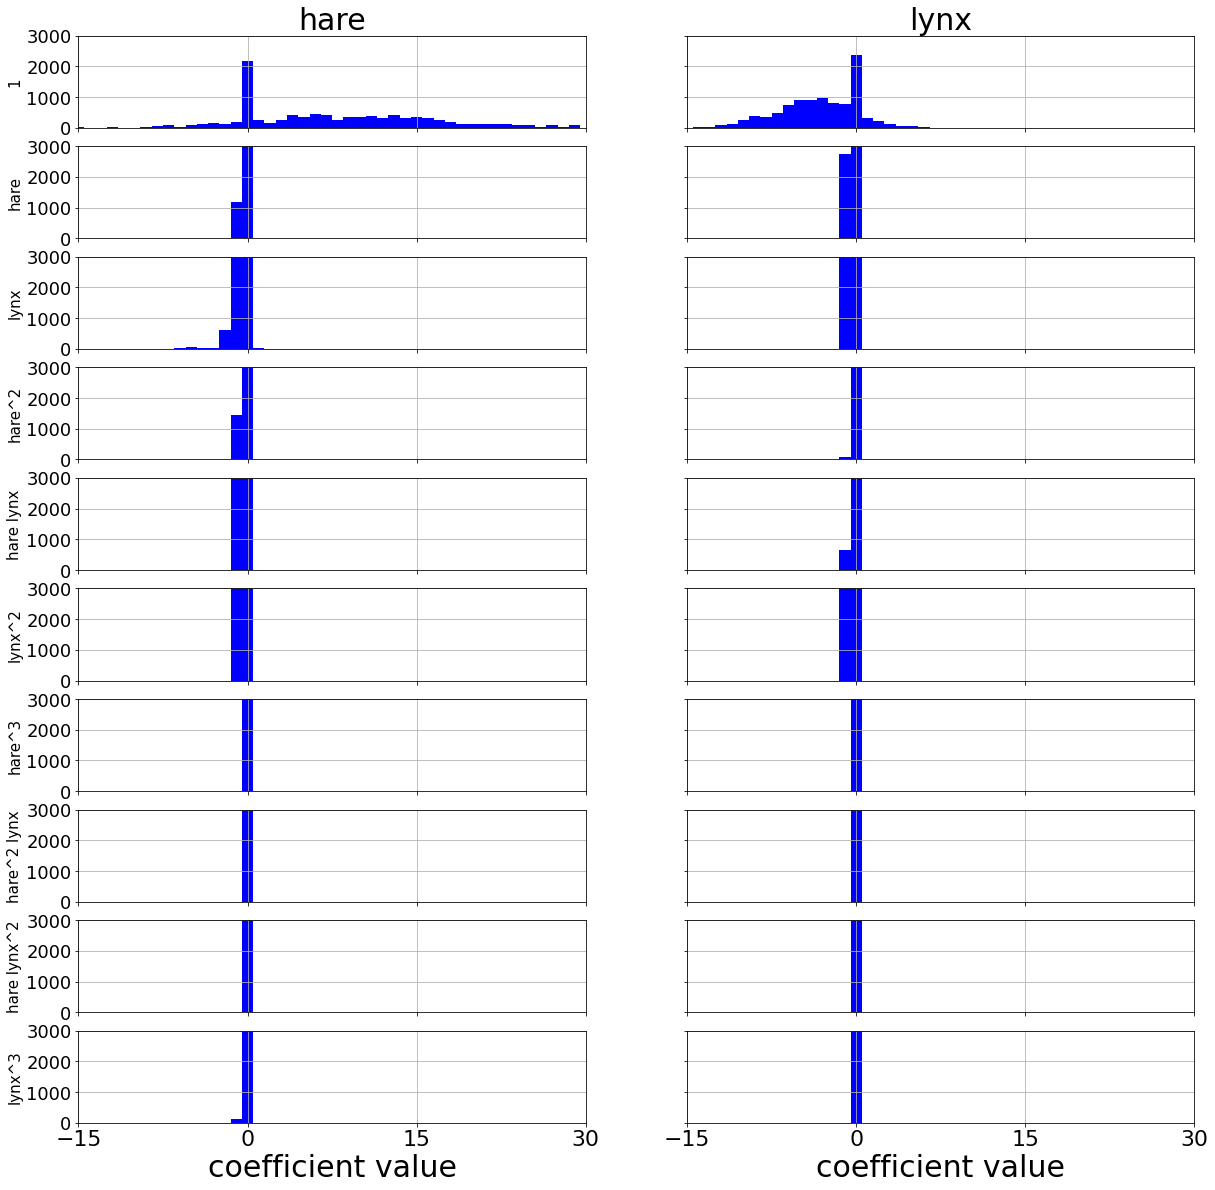

In [5]:
# Plotting fo the distributions (both bagging)

xticknames = model_bag.get_feature_names()

plt.figure(figsize=(20, 20), facecolor="white")
min_overall = -15
max_overall = 30

coefs_bag = np.asarray(coefs_bag)

# Loop through each element in the coefficients
num_feat = len(feat_names)
for j in range(10):
    for i in range(num_feat):
        plt.subplot(10, num_feat, i + 1 + j * num_feat)
        if j == 0:
            plt.title(feat_names[i], fontsize=30)
        bins = np.linspace(min_overall, max_overall, max_overall - min_overall + 1)
        plt.hist(coefs_bag[:, i, j], color='b', bins=bins, 
                 label='ensemble', align='left')
        # plt.hist(library_ensemble_coefs[:, i, j], bins=bins, 
        #          color='r', alpha=0.5, label='library ensemble', align='left')
        # plt.scatter(true_coefs[i, j], 110.0, color='k', 
        #             label='true value', s=100, marker='o')
        plt.grid(True)
        ax = plt.gca()
        if i == 0:
            plt.ylabel(xticknames[j], fontsize=15)
        else:
            ax.set_yticklabels([])
        if j != 9:
            ax.set_xticklabels([])
        else:
            plt.xlabel('coefficient value', fontsize=30)
        ax.set_xticks([min_overall, 0, max_overall // 2, max_overall])
        plt.ylim(0, 3000)
        plt.xlim(min_overall, max_overall)
        plt.xticks(fontsize=22)
        plt.yticks(fontsize=18)

plt.savefig(os.path.join(image_dir, "both_bag_hist"))
plt.show()

In [6]:
# Averagin and extracting mean or median for every coefficiant

# bag_shape = coefs_bag.shape[1:]
# mean_coef = np.zeros(bag_shape)
# median_coef = np.zeros(bag_shape)

# for i in range(bag_shape[0]):
#     for j in range(bag_shape[1]):
#         mean_coef[i,j] = np.mean(coefs_bag[:,i,j])
#         median_coef[i,j] = np.median(coefs_bag[:,i,j])

# # prediction mean

# model_bag.optimizer.coef_ = mean_coef
# sim = model_bag.simulate([hare0, lynx0], t=t_test, integrator="odeint")
# plt.plot(t_test, sim[:, 0], "r--", label="SINDy hare", linewidth=3)
# plt.plot(t_test, sim[:, 1], "b--", label="SINDy Lynx", linewidth=3)
# plt.grid()
# plt.xlabel("time, years")
# plt.ylabel("population, thousands")
# plt.legend()

# PER QUALCHE MOTIVO IL CODICE QUA DA ERRORE. NON RIESCO A CAPACITARMENE

del model_bag, coefs_bag

# Pysindy, only samples bagging
Since make predictions with library bagging seems impossible, we evaluate only samples bagging, and then the unstable models are removed.

In [7]:
diff_method_s = ps.FiniteDifference(order=2)
feat_library_s = ps.PolynomialLibrary(degree=3)
optimizer_s = ps.STLSQ(threshold=0.001, max_iter=200, alpha = alpha)


model_s = ps.SINDy(
    differentiation_method=diff_method_s,
    feature_library=feat_library_s,
    optimizer=optimizer_s,
    feature_names=feat_names,
)

model_s.fit(
    X_train,
    t=t_train,
    ensemble=True,
    replace=False,
    n_subset=80, # number of time points to use for ensemble
    n_models=200,
    quiet = True,
)

coefs_s = model_s.coef_list
model_s.print() # Printing THE LAST MODEL ONLY

(hare)' = 10.215 1 + 0.146 hare + -0.612 lynx + 0.001 lynx^2
(lynx)' = -5.671 1 + -0.064 hare + 0.365 lynx + 0.001 hare^2 + 0.001 hare lynx + -0.007 lynx^2


In [8]:
from sklearn.metrics import mean_squared_error

# function to compute the average of the coefficients, 
# weighted by the MSE on the test data.
def weighted_coefficient_average(coef_list, x_test, dt, optimizer):
    mse = np.zeros(np.shape(coef_list)[0])
    for i in range(np.shape(coef_list)[0]):
        optimizer.coef_ = np.asarray(coef_list)[i, :, :]
        mse[i] = model_s.score(x_test, t=dt, metric=mean_squared_error,)
    avg = np.average(coef_list, axis=0, weights=mse)
    coef_subtracted = np.zeros(np.shape(coef_list))
    for i in range(np.shape(coef_list)[0]):
        coef_subtracted[i, :, :] = np.asarray(coef_list)[i, :, :] - avg
    std = np.sqrt(np.average(coef_subtracted ** 2, axis=0, weights=mse))
    return avg, std

e_wavg, e_wstd = weighted_coefficient_average(
    coefs_s, X_train, dt, optimizer_s
)

# function to zero out any short-term unstable models 
def integration_metric(coef_list, optimizer):
    #t_test = np.arange(0, 2, 0.001)    
    # Try 5 test trajectories
    unst_count = 0
    negative_count= 0
    idx_st =  []
    # for k in range(5):
        # x0_test = (np.random.rand(3) - 0.5) * 10
    idx_0 = np.random.randint(low=0, high=30, size=(1,))
    test_0 = X_train[idx_0,:].reshape(2)
    #x_test = model.simulate(test_0 , t=t_test)
    #x_test = solve_ivp(lorenz, t_test_span, x0_test, t_eval=t_test).y.T
    for i in range(np.shape(coef_list)[0]):
        optimizer.coef_ = coef_list[i, :, :]
        x_test_sim = model_s.simulate(list(test_0), t_test, integrator="odeint")
        if np.any(np.abs(x_test_sim) > 250):
            # print('unstable model!')
            unst_count += 1
        # elif np.any(x_test_sim < 0):
        #     negative_count += 1
        else:
            idx_st.append(i)

    stable_coef_list = coef_list[idx_st,:,:]
    print(f"unstable models found: {unst_count}")
    print(f"models with negative predictions found: {negative_count}")
    #print(i)
    return stable_coef_list

stable_en_coefs = integration_metric(
    np.asarray(coefs_s), optimizer_s
)

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1870325805637D+04   r2 =  0.9400390573291D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1870325805637D+04   r2 =  0.9400390573291D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1870325805637D+04   r2 =  0.9400390573291D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1863024870418D+04   r2 =  0.9281907883402D-13
 lsoda--  warning..internal t (=r1) 

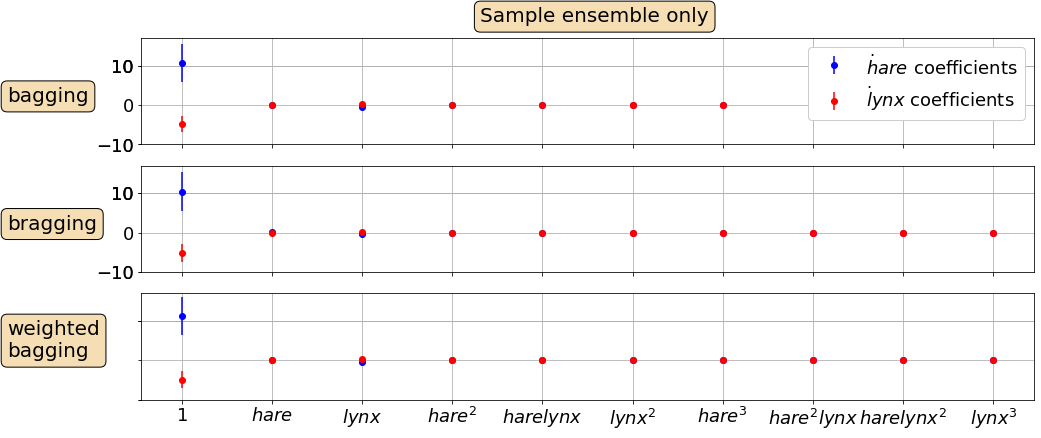

In [17]:
# Plot bagging, bragging, and other post-processing results with error bars
coef_types = [np.mean(stable_en_coefs , axis=0), 
              e_wavg,
              np.median(stable_en_coefs , axis=0),
              #np.mean(stable_ensemble_coefs, axis=0), 
             ]
coef_stds = [np.std(stable_en_coefs, axis=0), 
             e_wstd,
             np.std(stable_en_coefs, axis=0), 
             #np.std(stable_ensemble_coefs, axis=0), 
             ]

# define some plotting needs
colors = ['b', 'r', 'k']
props = dict(boxstyle='round', facecolor='wheat', alpha=1.0)
textstrs = ['bagging', 'bragging', 'weighted\nbagging', 
            'stability\nweighted\nbagging']
plt.figure(figsize=(16, 9),facecolor='white',)

# Loop over the different post-processed coefficients
xticknames = model_s.get_feature_names()
for k, coefs in enumerate(coef_types):
    coef_std = coef_stds[k]
    plt.subplot(4, 1, k + 1)
    for i in range(coefs.shape[0]):
        plt.errorbar(range(coefs.shape[1]), coefs[i, :], yerr=coef_std[i, :], 
                     fmt='o', color=colors[i], 
                     label='$\dot ' + feat_names[i] + '_{}$' + ' coefficients')
    ax = plt.gca()
    ax.set_xticks(range(len(xticknames)))

    # Inferiori x_labels
    if k >= 2:
        for i in range(len(xticknames)):
            xticknames[i] = '$' + xticknames[i] + '$'
        ax.set_xticklabels(xticknames, verticalalignment='top', fontsize=10)
    else:
        ax.set_xticklabels([])
    plt.ylim(-10, 17)

    # Legend in the first plot
    if k == 0:
        plt.legend(fontsize=18, framealpha=1.0, loc='upper right')
        ax.text(0.38, 1.15, 'Sample ensemble only', transform=ax.transAxes, 
                fontsize=20, bbox=props)
    # if k == 1:
    #     ax.text(0.35, 1.15, 'library ensemble', transform=ax.transAxes, 
    #             fontsize=20, bbox=props)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(True)
    ax.set_yticks([-10, -10, 0, 10, 10, 10])
    
    textstr = textstrs[k]
    ax.text(-0.15, 0.4, textstr, transform=ax.transAxes, 
            fontsize=20, bbox=props)
    if k == 2:
        ax.set_yticklabels([])
    
plt.savefig(os.path.join(image_dir, "Sbag_coef"))

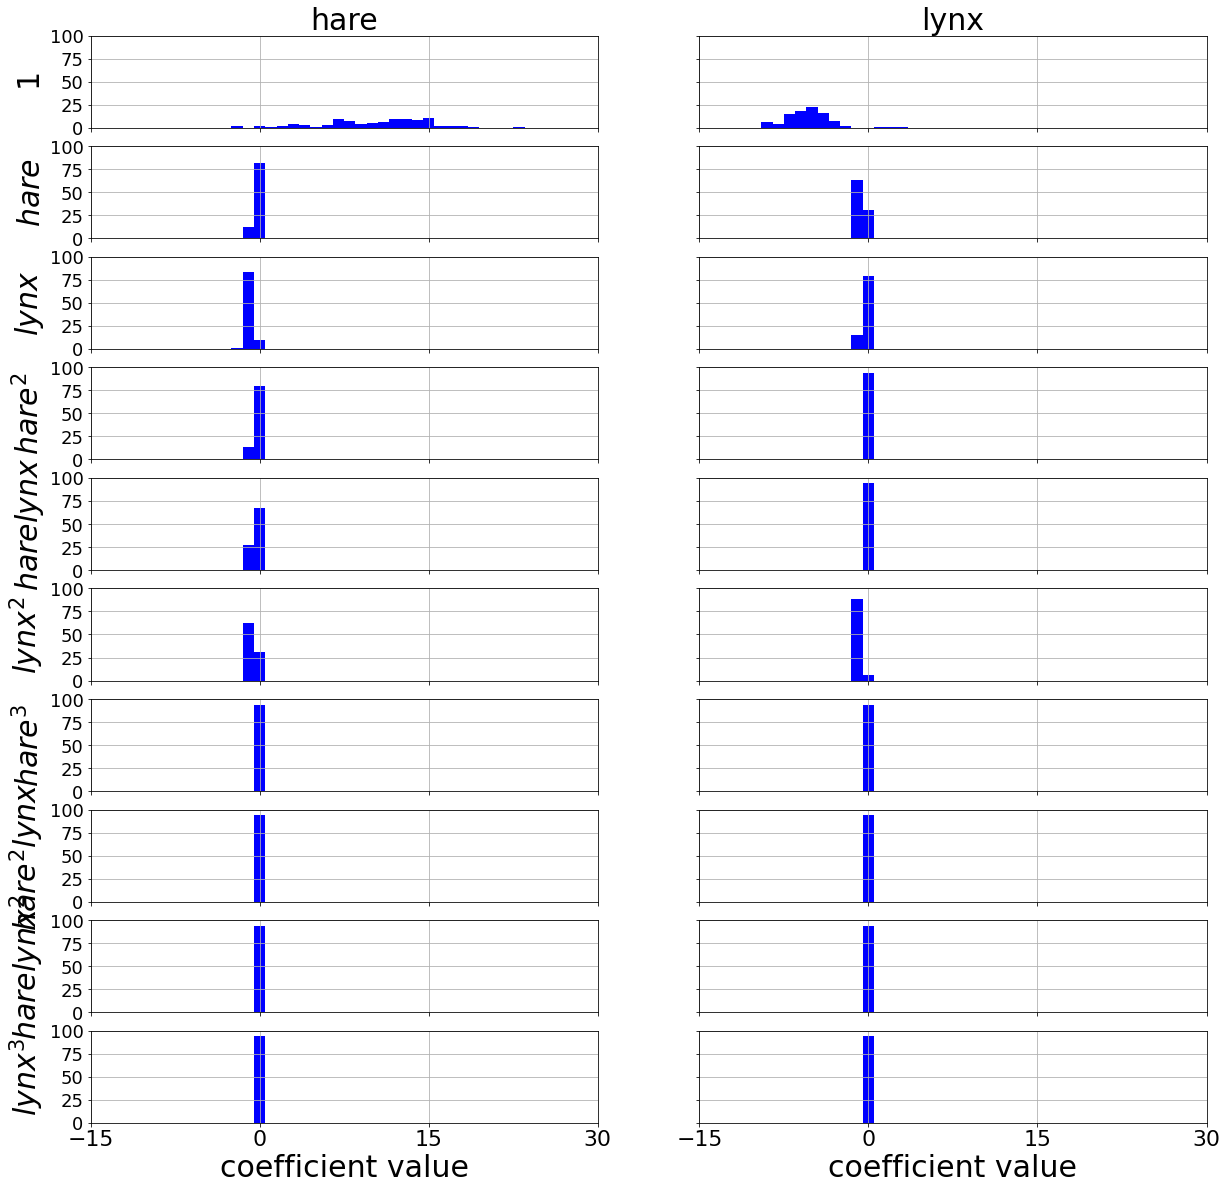

In [10]:
# Make plots of each coefficient distribution!
plt.figure(figsize=(20, 20), facecolor="white")
min_overall = -15
max_overall = 30

# Loop through each element in the coefficients
num_feat = len(feat_names)
for j in range(10):
    for i in range(num_feat):
        plt.subplot(10, num_feat, i + 1 + j * num_feat)
        if j == 0:
            plt.title(feat_names[i], fontsize=30)
        bins = np.linspace(min_overall, max_overall, max_overall - min_overall + 1)
        plt.hist(stable_en_coefs[:, i, j], color='b', bins=bins, 
                 label='ensemble', align='left')
        # plt.hist(library_ensemble_coefs[:, i, j], bins=bins, 
        #          color='r', alpha=0.5, label='library ensemble', align='left')
        # plt.scatter(true_coefs[i, j], 110.0, color='k', 
        #             label='true value', s=100, marker='o')
        plt.grid(True)
        ax = plt.gca()
        if i == 0:
            plt.ylabel(xticknames[j], fontsize=30)
        else:
            ax.set_yticklabels([])
        if j != 9:
            ax.set_xticklabels([])
        else:
            plt.xlabel('coefficient value', fontsize=30)
        ax.set_xticks([min_overall, 0, max_overall // 2, max_overall])
        plt.ylim(0, 100)
        plt.xlim(min_overall, max_overall)
        plt.xticks(fontsize=22)
        plt.yticks(fontsize=18)
        if i == 2 and j == 9:
            plt.legend(fontsize=16)

# Predictions!



In [11]:
mean_ensemble_coefs = np.mean(stable_en_coefs, axis=0)
median_ensemble_coefs = np.median(stable_en_coefs, axis=0)

#t_test = t_test[:40]

# The mean value for every weight is passed to the optimizer for a simulation
optimizer_s.coef_ = mean_ensemble_coefs
x_test_sim_mean = model_s.simulate([hare0, lynx0], t_test,integrator="odeint") #integrator='odeint'

# The meidat value for every weight is passed to the optimizer for a simulation
optimizer_s.coef_ = median_ensemble_coefs
x_test_sim_median = model_s.simulate([hare0, lynx0], t_test,integrator="odeint")

# Predict the testing trajectory with all the models (passing the 
# model.coef_list to the optimizer at every run).

# We may preallocate.... 
x_test_sims = []
for i in range(stable_en_coefs.shape[0]):
    optimizer_s.coef_ = stable_en_coefs[i, :, :]
    x_test_sims.append(model_s.simulate([hare0, lynx0], t=t_test, integrator="odeint"))

# Super inefficiente....

      in above,  r1 =  0.1867139637021D+04   r2 =  0.8421493702728D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1867139637021D+04   r2 =  0.6837371693916D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1868391793741D+04   r2 =  0.1066501654624D-12
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1868391793741D+04   r2 =  0.1066501654624D-12
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.18683917937

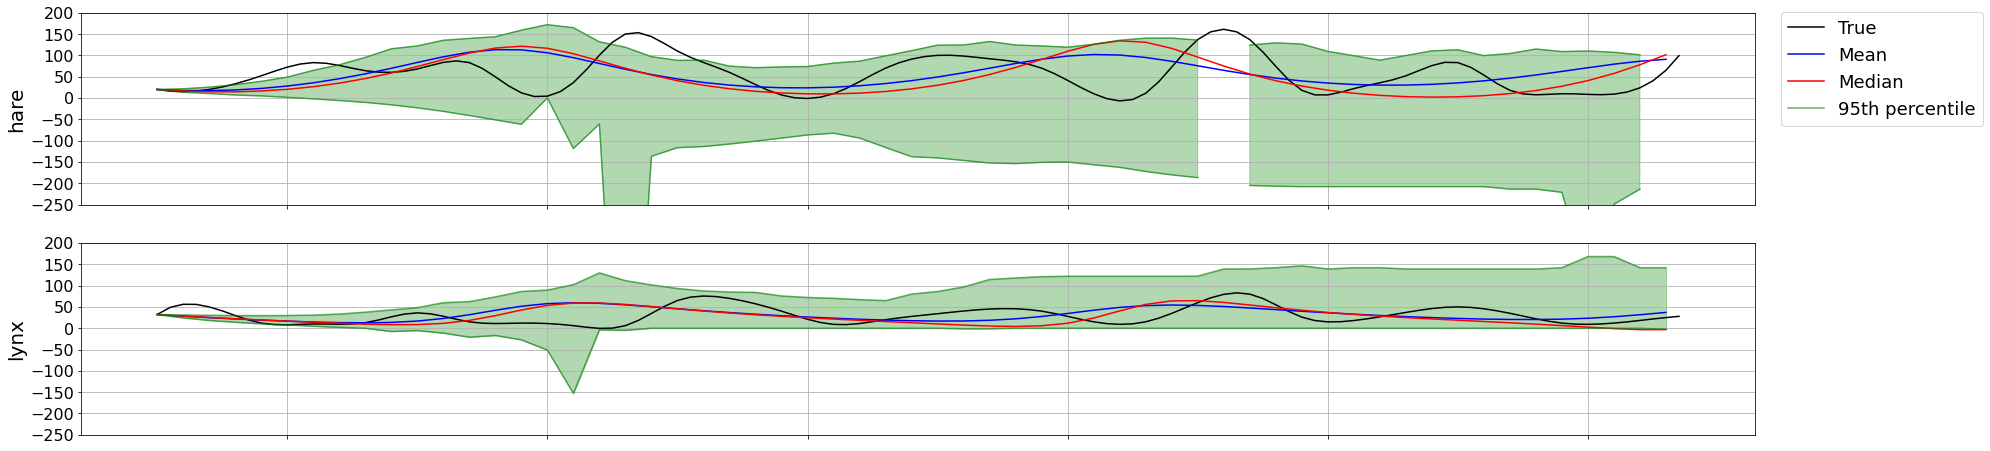

In [25]:
# Compute the 2.5 and 97.5 percentile trajectories
bottom_line = np.percentile(np.asarray(x_test_sims), 2.5, axis=0)
top_line = np.percentile(np.asarray(x_test_sims), 97.5, axis=0)

# Plot trajectory results
plt.figure(figsize=(30, 12),facecolor="white")
for i in range(2):
    plt.subplot(3, 1, i + 1)
    plt.plot(t_train, X_train[:, i], 'k', label='True')
    plt.plot(t_test, x_test_sim_mean[:, i], 'b', label='Mean')
    plt.plot(t_test, x_test_sim_median[:, i], 'r', label='Median')
    plt.plot(t_test, bottom_line[:, i], 'g', alpha=0.6, label='95th percentile')
    plt.plot(t_test, top_line[:, i], 'g', alpha=0.6,)
    ax = plt.gca()
    ax.fill_between(t_test, bottom_line[:, i], top_line[:, i], color='g', alpha=0.3)
    plt.ylim(-250, 200)
    plt.grid(True)
    if i != 2:
        ax.set_xticklabels([])
    else:
        plt.xlabel('t', fontsize=20)
    plt.ylabel(feat_names[i], fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    #ax.yaxis.set_label_coords(-0.05, 0.75 - 0.1 * (i + 1))
    if i == 0:
        ax.legend(bbox_to_anchor=(1.01, 1.05), fontsize=18)

plt.savefig(os.path.join(image_dir, "Sbag_pred"))